In [1]:
import numpy as np # need
from scipy.integrate import odeint  # need
from random import uniform

import pandas as pd

import matplotlib.pyplot as plt
%matplotlib inline

from tyssue import Sheet, PlanarGeometry
from tyssue.draw import sheet_view

from scipy.integrate import solve_ivp
geom = PlanarGeometry

# Point de vue d'une jonction

time_step :  0.014


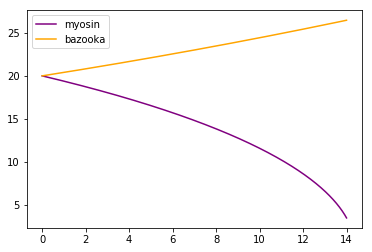

In [2]:
## tests du point de vue d'une jonction
# https://www.youtube.com/watch?v=zRMmiBMjP9o


qmyosin = 0
qbazooka = 0.02
k1 = 0.6
k2 = 0


def myosin_bazooka_interaction(x, t):
    c_myosin  = x[0]
    c_bazooka = x[1]
    
    dmyosin_dt = qmyosin*c_myosin - k1 *c_bazooka/c_myosin
    dbazooka_dt = qbazooka*c_bazooka - k2*c_myosin/c_bazooka
    
    return [dmyosin_dt, dbazooka_dt]

#test de la fonction
#print(myosin_bazooka_interaction([10.,20.], 0))

# simulation
x0 = [20., 20.] # Conditions initiales
t_max = 14
step = 1000
t = np.linspace(0, t_max, step)
print("time_step : ", t_max/step)

x = odeint(myosin_bazooka_interaction, x0, t)

myosin = x[:,0]
bazooka = x[:,1]

plt.plot(t,myosin, color = 'purple')
plt.plot(t,bazooka, color = 'orange')
plt.legend(['myosin', 'bazooka'])


# Point de vue d'une cellule

time_step :  0.001


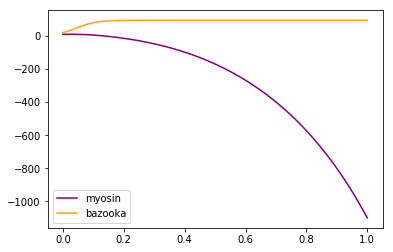

In [3]:
# test du point de vue de la cellule. 

#auto-recrutement
qmyosin = 0.1
qbazooka = 0.3
#desorption
amyosin = 0.05
abazooka = 0.05
#inhibition
k = 2



def myosin_bazooka_interaction(x, t):
    c_myosin  = np.split(x,2)[0]
    c_bazooka = np.split(x,2)[1]
    
    dmyosin_dt = []
    dbazooka_dt = []
    for i in range (0, len(c_myosin)):
        dmyosin_dt.append(qmyosin*c_myosin[i]*(100-np.sum(c_myosin)) - amyosin*c_myosin[i] - k*c_bazooka[i])
        dbazooka_dt.append(qbazooka*c_bazooka[i]*(100-np.sum(c_bazooka)) - abazooka*c_bazooka[i])
    
    return np.concatenate((dmyosin_dt, dbazooka_dt), axis = None)

#test de la fonction
#print(myosin_bazooka_interaction([[10.,20.], [1., 20.]], 0))

# simulation
x0_myosin = [20., 10.]
x0_bazooka = [1., 20.]
x0 = np.concatenate((x0_myosin, x0_bazooka), axis = None) # Conditions initiales
t_max = 1
step = 1000
t = np.linspace(0, t_max, step)
print("time_step : ", t_max/step)

x = odeint(myosin_bazooka_interaction, x0, t)

myosin = x[:,1]
bazooka = x[:,3]

plt.plot(t,myosin, color = 'purple')
plt.plot(t,bazooka, color = 'orange')
plt.legend(['myosin', 'bazooka'])


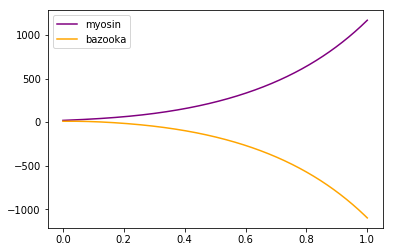

In [4]:
myosin = x[:,0]
bazooka = x[:,1]

plt.plot(t,myosin, color = 'purple')
plt.plot(t,bazooka, color = 'orange')
plt.legend(['myosin', 'bazooka'])

### Test sur une cellule issu d'un sheet. 
=> test sur la structure de données

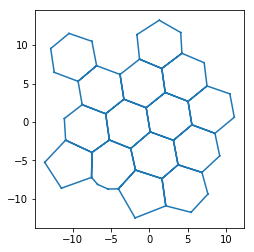

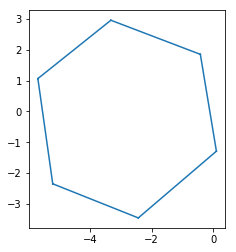

In [5]:

from tyssue.io import hdf5
from tyssue.stores import stores_dir
from tyssue.draw.plt_draw import quick_edge_draw
from tyssue.config.geometry import cylindrical_sheet
import os

h5store = os.path.join(stores_dir, "15_cells_patch.hf5")

datasets = hdf5.load_datasets(h5store, data_names=["face", "vert", "edge"])
specs = cylindrical_sheet()
sheet = Sheet("emin", datasets, specs)

# Modify some initial value
sheet.settings['threshold_length'] = 1e-3
sheet.vert_df['radial_tension'] = 0.

fig, ax = quick_edge_draw(sheet, coords=list('xy'))
sheet.get_opposite()

sheet.remove(sheet.edge_df[sheet.edge_df.face.isin(sheet.face_df.loc[:13].index)].index)
fig, ax = quick_edge_draw(sheet, coords=list('xy'))
sheet.get_opposite()

In [6]:
# Mettre des valeurs de base pour la myosine et bazooka sur chaque bord de la cellule
sheet.face_df['myosin_max'] = 100
sheet.face_df['bazooka_max'] = 100

sheet.edge_df['myosin']  = [5 , 20, 15, 10, 18, 10]
sheet.edge_df['bazooka'] = [20, 1 , 5 , 15, 20, 10]

time_step :  0.005


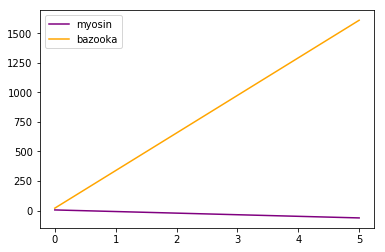

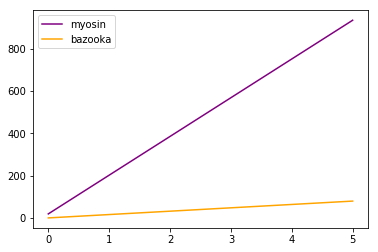

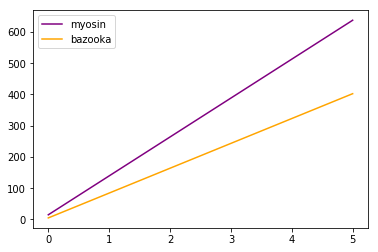

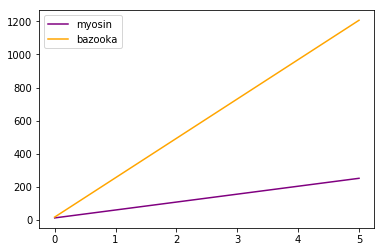

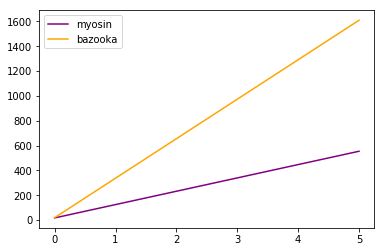

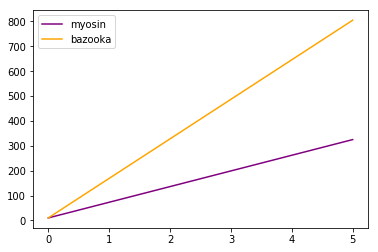

In [7]:
#auto-recrutement
qmyosin = 0.1
qbazooka = 0.2
#desorption
amyosin = 0.2
abazooka = 0.1
#inhibition
k = 3



def myosin_bazooka_interaction(x0, t, sheet):
    
    c_myosin  = sheet.edge_df.myosin
    c_bazooka = sheet.edge_df.bazooka
    
    dmyosin_dt = []
    dbazooka_dt = []
    
    for e in sheet.edge_df.itertuples() : 
        dmyosin_dt.append(qmyosin*e.myosin*(sheet.face_df.loc[e.face].myosin_max-
                                            np.sum(sheet.edge_df.loc[e.face].myosin)) 
                           - amyosin*e.myosin 
                           - k*e.bazooka)
        
        dbazooka_dt.append(qbazooka*e.bazooka*(sheet.face_df.loc[e.face].bazooka_max-
                                              np.sum(sheet.edge_df.loc[e.face].bazooka))
                          - abazooka*e.bazooka)
    

    return np.concatenate((dmyosin_dt, dbazooka_dt), axis = None)

#test de la fonction
#print(myosin_bazooka_interaction(sheet, 0))

# simulation
x0 = np.concatenate((sheet.edge_df.myosin, sheet.edge_df.bazooka), axis = None) # Conditions initiales
t_max = 5
step = 1000
t = np.linspace(0, t_max, step)
print("time_step : ", t_max/step)

x = odeint(myosin_bazooka_interaction, x0, t, (sheet,))

for i in range(0,6):
    myosin = x[:,i]
    bazooka = x[:,i+6]

    plt.plot(t,myosin, color = 'purple')
    plt.plot(t,bazooka, color = 'orange')
    plt.legend(['myosin', 'bazooka'])
    plt.show()


# Point de vue de plusieurs cellules

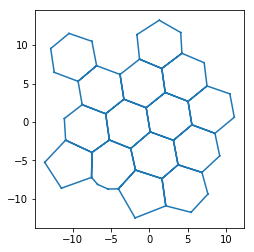

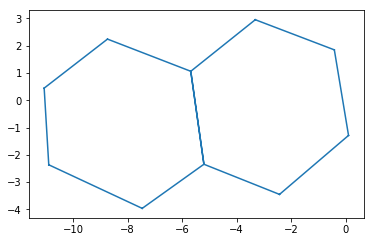

In [47]:
from tyssue.io import hdf5
from tyssue.stores import stores_dir
from tyssue.draw.plt_draw import quick_edge_draw
from tyssue.config.geometry import cylindrical_sheet
import os

h5store = os.path.join(stores_dir, "15_cells_patch.hf5")

datasets = hdf5.load_datasets(h5store, data_names=["face", "vert", "edge"])
specs = cylindrical_sheet()
sheet = Sheet("emin", datasets, specs)

# Modify some initial value
sheet.settings['threshold_length'] = 1e-3
sheet.vert_df['radial_tension'] = 0.

fig, ax = quick_edge_draw(sheet, coords=list('xy'))
sheet.get_opposite()

sheet.remove(sheet.edge_df[sheet.edge_df.face.isin(sheet.face_df.loc[:12].index)].index)
fig, ax = quick_edge_draw(sheet, coords=list('xy'))
sheet.get_opposite()

In [48]:
# Mettre des valeurs de base pour la myosine et bazooka sur chaque bord de la cellule
sheet.face_df['myosin_max'] = 100
sheet.face_df['bazooka_max'] = 100

sheet.edge_df['myosin']  = [5 , 20, 15, 10, 18, 10, 5 , 20, 15, 10, 18, 10]
sheet.edge_df['bazooka'] = [20, 1 , 5 , 15, 20, 10, 20, 15, 5 , 1 , 20, 10]
#sheet.edge_df['myosin'] /= 10
#sheet.edge_df['bazooka'] /= 10
sheet.edge_df
sheet_init = sheet.copy(deep_copy=True)

In [41]:
"""#auto-recrutement
qmyosin = 0.67
qbazooka = 0.9
#desorption
amyosin = 0.27*np.exp(-4.02)
#amyosin = 0.7*np.exp(-0.102)
abazooka = 0.05
#inhibition
k = 0.6
#enrichissement edge oppose
qob = 0.5"""

#auto-recrutement
qmyosin = 0.2
qbazooka = 0.6
#desorption
amyosin = 0.1
abazooka = 0.1
#inhibition
k = 0.6
#enrichissement edge oppose
qob = 0.7

sheet=sheet_init.copy(deep_copy=True)

def myosin_bazooka_interaction(x0, t, sheet):
    #print('t : ', t)

    dmyosin_dt = []
    dbazooka_dt = []
    
    for e in sheet.edge_df.itertuples() : 
        
        #Myosin
        m_cyto = (sheet.face_df.loc[e.face].myosin_max
                  - sheet.edge_df.loc[sheet.edge_df.face == e.face].myosin.sum())

        m = (qmyosin*e.myosin*m_cyto
             - amyosin*e.myosin 
             - k*e.bazooka)
       
        if m < -e.myosin:
            dmyosin_dt.append(-e.myosin)
            sheet.edge_df.loc[e.Index, 'myosin'] += -e.myosin
        elif m > m_cyto:
            if m_cyto < 0:
                dmyosin_dt.append(e.myosin)
                sheet.edge_df.loc[e.Index, 'myosin'] += e.myosin
            else : 
                dmyosin_dt.append(m_cyto)
                sheet.edge_df.loc[e.Index, 'myosin'] +=  m_cyto
        else: 
            dmyosin_dt.append(m)
            sheet.edge_df.loc[e.Index, 'myosin'] += m
        
        
        #Bazooka
        b_cyto = (sheet.face_df.loc[e.face].bazooka_max
                  - sheet.edge_df.loc[sheet.edge_df.face == e.face].bazooka.sum())
        
        b = (qbazooka*e.bazooka*b_cyto
            - abazooka*e.bazooka)
        
        if e.opposite != -1:
            b += qob*sheet.edge_df.loc[e.opposite].bazooka
            
        if b < -e.bazooka :
            dbazooka_dt.append(-e.bazooka)
            sheet.edge_df.loc[e.Index, 'bazooka'] += -e.bazooka
        elif b > b_cyto:
            if b_cyto < 0:
                dbazooka_dt.append(e.bazooka)
                sheet.edge_df.loc[e.Index, 'bazooka'] += e.bazooka
            else :
                dbazooka_dt.append(b_cyto)
                sheet.edge_df.loc[e.Index, 'bazooka'] += b_cyto
        else: 
            dbazooka_dt.append(b)
            sheet.edge_df.loc[e.Index, 'bazooka'] += b

    
    return np.concatenate((dmyosin_dt, dbazooka_dt), axis = None)
    

# simulation
x0 = np.concatenate((sheet.edge_df.myosin, sheet.edge_df.bazooka), axis = None) # Conditions initiales
time_step = 0.1
t_max = 1
step = int(t_max/time_step)
t = np.linspace(0, t_max, step)
print("time_step : ", t_max/step)
print("step :",  step)

x, info_dict = odeint(myosin_bazooka_interaction, x0, t, (sheet,), full_output=True)

for i in range(0,12):
    myosin =  x[:,i]
    bazooka =  x[:,i+12-1]+ x[:,i+12]

    plt.plot(t,myosin, color = 'purple')
    plt.plot(t,bazooka, color = 'orange')
    plt.legend(['myosin', 'bazooka'])
    plt.show()

time_step :  0.1
step : 10


KeyboardInterrupt: 

In [121]:
"""#auto-recrutement
qmyosin = 0.67
qbazooka = 0.9
#desorption
amyosin = 0.27*np.exp(-4.02)
#amyosin = 0.7*np.exp(-0.102)
abazooka = 0.05
#inhibition
k = 0.6
#enrichissement edge oppose
qob = 0.5"""

#auto-recrutement
qmyosin = 0.67
qbazooka = 0.02
#desorption
amyosin = 0.27
abazooka = 0.05
#inhibition
k = 0.6
#enrichissement edge oppose
qob = 0.8

sheet=sheet_init.copy(deep_copy=True)

def myosin_bazooka_interaction(x0, t, sheet):
    #print('t : ', t)

    dmyosin_dt = []
    dbazooka_dt = []
    
    for e in sheet.edge_df.itertuples() : 
        
        #Myosin
        m_cyto = (sheet.face_df.loc[e.face].myosin_max
                  - sheet.edge_df.loc[sheet.edge_df.face == e.face].myosin.sum())

        m = (qmyosin*e.myosin*m_cyto
             - amyosin*e.myosin 
             - k*e.bazooka)
       
        if m < -e.myosin:
            dmyosin_dt.append(-e.myosin)
            sheet.edge_df.loc[e.Index, 'myosin'] += -e.myosin
        elif m > m_cyto:
            if m_cyto < 0:
                dmyosin_dt.append(e.myosin)
                sheet.edge_df.loc[e.Index, 'myosin'] += e.myosin
            else : 
                dmyosin_dt.append(m_cyto)
                sheet.edge_df.loc[e.Index, 'myosin'] +=  m_cyto
        else: 
            dmyosin_dt.append(m)
            sheet.edge_df.loc[e.Index, 'myosin'] += m
        
        
        #Bazooka
        b_cyto = (sheet.face_df.loc[e.face].bazooka_max
                  - sheet.edge_df.loc[sheet.edge_df.face == e.face].bazooka.sum())
        
        b = (qbazooka*e.bazooka*b_cyto
            - abazooka*e.bazooka)
        
        if e.opposite != -1:
            b += qob*sheet.edge_df.loc[e.opposite].bazooka
            
        if b < -e.bazooka :
            dbazooka_dt.append(-e.bazooka)
            sheet.edge_df.loc[e.Index, 'bazooka'] += -e.bazooka
        elif b > b_cyto:
            if b_cyto < 0:
                dbazooka_dt.append(e.bazooka)
                sheet.edge_df.loc[e.Index, 'bazooka'] += e.bazooka
            else :
                dbazooka_dt.append(b_cyto)
                sheet.edge_df.loc[e.Index, 'bazooka'] += b_cyto
        else: 
            dbazooka_dt.append(b)
            sheet.edge_df.loc[e.Index, 'bazooka'] += b

    
    return np.concatenate((dmyosin_dt, dbazooka_dt), axis = None)
    

# simulation
x0 = np.concatenate((sheet.edge_df.myosin, sheet.edge_df.bazooka), axis = None) # Conditions initiales
time_step = 0.1
t_max = time_step + 2
step = int(t_max/time_step)
t = np.arange(0, t_max, time_step)
print("time_step : ", t_max/step)
print("step :",  step)

x_myosin=[]
x_bazooka=[]

for i in range(len(t)-1):
    ts = [t[i], t[i+1]]
    x = odeint(myosin_bazooka_interaction, x0, t, (sheet,))
    x_myosin.append(x[:,:12])
    x_bazooka.append(x[:,12:])
    x0 = np.concatenate((sheet.edge_df.myosin, sheet.edge_df.bazooka), axis = None) # Conditions initiales
    

for i in range(0,12):
    myosin=[]
    bazooka=[]
    for m in x_myosin:
        myosin.append(m[0][i])
    for b in x_bazooka:
        bazooka.append(b[0][i])

    plt.plot(myosin, color = 'purple')
    plt.plot(bazooka, color = 'orange')
    plt.legend(['myosin', 'bazooka'])
    plt.title((i,i+12))
    plt.show()

time_step :  0.1
step : 201


/home/admin-suz/anaconda3/lib/python3.6/site-packages/scipy/integrate/odepack.py:247: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)


KeyboardInterrupt: 

Text(0.5,1,'myosin')

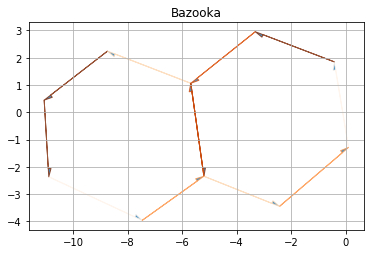

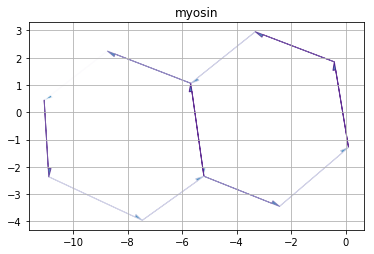

In [116]:
# Forme du tissu au debut
sheet2 = sheet_init.extract_bounding_box(y_boundary=[-100,100], x_boundary = [-200,200], z_boundary=[-400,400])
fig, ax = sheet_view(sheet2, edge={'color':sheet2.edge_df.bazooka, 'width':1, 'colormap':'Oranges'}, 
                     vert={'visible':False}, coords = ['x','y'])
ax.set_title('Bazooka')

fig, ax = sheet_view(sheet2, edge={'color':sheet2.edge_df.myosin, 'width':1, 'colormap':'Purples'}, 
                     vert={'visible':False}, coords = ['x','y'])
ax.set_title('myosin')


Text(0.5,1,'myosin')

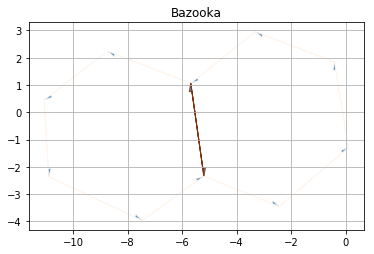

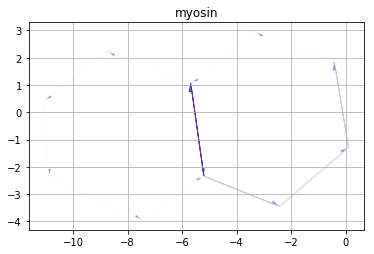

In [125]:
# Forme du tissu au debut
sheet3 = sheet.extract_bounding_box(y_boundary=[-100,100], x_boundary = [-200,200], z_boundary=[-400,400])
fig, ax = sheet_view(sheet3, edge={'color':sheet3.edge_df.bazooka, 'width':1, 'colormap':'Oranges'}, 
                     vert={'visible':False}, coords = ['x','y'])
ax.set_title('Bazooka')

fig, ax = sheet_view(sheet3, edge={'color':sheet3.edge_df.myosin, 'width':1, 'colormap':'Purples'}, 
                     vert={'visible':False}, coords = ['x','y'])
ax.set_title('myosin')


# Test sur un plus grand tissu

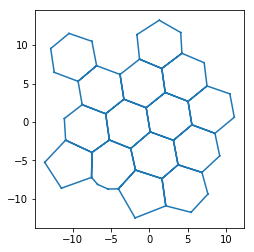

In [129]:
from tyssue.io import hdf5
from tyssue.stores import stores_dir
from tyssue.draw.plt_draw import quick_edge_draw
from tyssue.config.geometry import cylindrical_sheet
import os

h5store = os.path.join(stores_dir, "15_cells_patch.hf5")

datasets = hdf5.load_datasets(h5store, data_names=["face", "vert", "edge"])
specs = cylindrical_sheet()
sheet = Sheet("emin", datasets, specs)

# Modify some initial value
sheet.settings['threshold_length'] = 1e-3
sheet.vert_df['radial_tension'] = 0.

fig, ax = quick_edge_draw(sheet, coords=list('xy'))
sheet.get_opposite()


In [130]:
# Mettre des valeurs de base pour la myosine et bazooka sur chaque bord de la cellule
sheet.face_df['myosin_max'] = 100
sheet.face_df['bazooka_max'] = 100

sheet.edge_df['myosin'] = np.random.uniform(0, 30, sheet.Ne)
sheet.edge_df['bazooka'] = np.random.uniform(0, 30, sheet.Ne)

sheet_init = sheet.copy(deep_copy=True)

In [180]:
# Euler method
"""#auto-recrutement
qmyosin = 0.67
qbazooka = 0.9
#desorption
amyosin = 0.27*np.exp(-4.02)
#amyosin = 0.7*np.exp(-0.102)
abazooka = 0.05
#inhibition
k = 0.6
#enrichissement edge oppose
qob = 0.5"""

#auto-recrutement
qmyosin = 0.35
qbazooka = 0.67
#desorption
amyosin = 0.15
abazooka = 0.35
#inhibition
k = 0.6
#enrichissement edge oppose
qob = 0.8

sheet=sheet_init.copy(deep_copy=True)

def myosin_bazooka_interaction(sheet, dt):
   
    for e in sheet.edge_df.itertuples() : 
        
        ## Myosin
        # Myosin restante dans le cytoplasme
        m_cyto = (sheet.face_df.loc[e.face].myosin_max
                  - sheet.edge_df.loc[sheet.edge_df.face == e.face].myosin.sum())

        dm = (qmyosin*e.myosin*m_cyto
             - amyosin*e.myosin 
             - k*e.bazooka)*dt
       
        # si dm est plus petit que la quantite de myosine presente sur la jonction
        #      => soustrait la quantite de myosine de la jonction
        if dm < -e.myosin:
            sheet.edge_df.loc[e.Index, 'myosin'] += -e.myosin
        # si dm est plus grand que la quantite de myosine presente dans le cytoplasme
        elif dm > m_cyto:
            # s'il y a de la myosine dans le cytoplasme 
            #    => ajout de la myosine du cytoplasme a la jonction
            if m_cyto > 0:
                sheet.edge_df.loc[e.Index, 'myosin'] += m_cyto
        # Ajout directement de dm
        else: 
            sheet.edge_df.loc[e.Index, 'myosin'] += dm
        
        
        ## Bazooka
        # Bazooka restant dans le cytoplasme
        b_cyto = (sheet.face_df.loc[e.face].bazooka_max
                  - sheet.edge_df.loc[sheet.edge_df.face == e.face].bazooka.sum())
        
        db = (qbazooka*e.bazooka*b_cyto
            - abazooka*e.bazooka)
        
        if e.opposite != -1:
            db += qob*sheet.edge_df.loc[e.opposite].bazooka
        db *= dt
            
        if db < -e.bazooka :
            sheet.edge_df.loc[e.Index, 'bazooka'] += -e.bazooka
        elif db > b_cyto:
            if b_cyto > 0:
                sheet.edge_df.loc[e.Index, 'bazooka'] += b_cyto
            else: 
                sheet.edge_df.loc[e.Index, 'bazooka'] = e.bazooka

        else: 
            sheet.edge_df.loc[e.Index, 'bazooka'] += db

    
    

# simulation
time_step = 0.1
t_max = time_step + 10
step = int(t_max/time_step)
t = np.arange(0, t_max, time_step)
print("time_step : ", t_max/step)
print("step :",  step)

x_myosin=[]
x_bazooka=[]

for i in range(len(t)-1):
    #print (i)
    myosin_bazooka_interaction(sheet, time_step)
    

"""for i in range(sheet.Ne):
    myosin=[]
    bazooka=[]
    for m in x_myosin:
        myosin.append(m[0][i])
    for b in x_bazooka:
        bazooka.append(b[0][i])

    plt.plot(myosin, color = 'purple')
    plt.plot(bazooka, color = 'orange')
    plt.legend(['myosin', 'bazooka'])
    plt.title((i,i+12))
    plt.show()"""

time_step :  0.10099999999999999
step : 100


"for i in range(sheet.Ne):\n    myosin=[]\n    bazooka=[]\n    for m in x_myosin:\n        myosin.append(m[0][i])\n    for b in x_bazooka:\n        bazooka.append(b[0][i])\n\n    plt.plot(myosin, color = 'purple')\n    plt.plot(bazooka, color = 'orange')\n    plt.legend(['myosin', 'bazooka'])\n    plt.title((i,i+12))\n    plt.show()"

98.5 	 99.56
98.27 	 99.98
100.0 	 100.0
97.56 	 100.0
100.0 	 100.0
98.47 	 99.61
100.0 	 100.0
99.57 	 100.0
99.62 	 100.0
98.47 	 99.94
100.0 	 100.0
98.46 	 99.81
98.25 	 99.89
100.0 	 99.74
100.0 	 100.0


Text(0.5,1,'myosin')

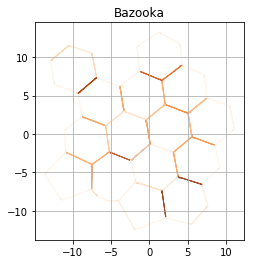

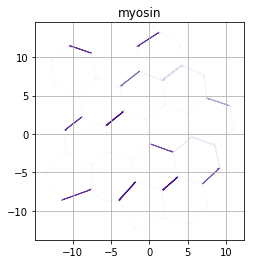

In [181]:
for i in range (sheet.Nf):
    print(round(sheet.edge_df.loc[sheet.edge_df.face == i].myosin.sum(),2),
          '\t',
          round(sheet.edge_df.loc[sheet.edge_df.face == i].bazooka.sum(),2))
# Forme du tissu à la fin
sheet3 = sheet.extract_bounding_box(y_boundary=[-100,100], x_boundary = [-200,200], z_boundary=[-400,400])
fig, ax = sheet_view(sheet3, edge={'color':sheet3.edge_df.bazooka, 'width':1, 'colormap':'Oranges'}, 
                     vert={'visible':False}, coords = ['x','y'])
ax.set_title('Bazooka')

fig, ax = sheet_view(sheet3, edge={'color':sheet3.edge_df.myosin, 'width':1, 'colormap':'Purples'}, 
                     vert={'visible':False}, coords = ['x','y'])
ax.set_title('myosin')


Text(0.5,1,'myosin')

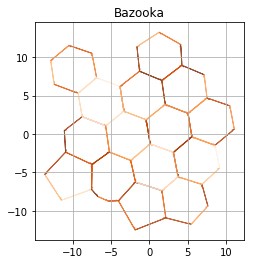

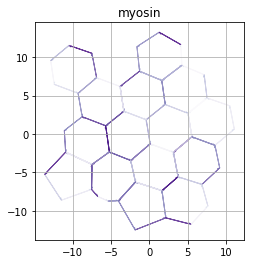

In [162]:
# Forme du tissu au debut
sheet2 = sheet_init.extract_bounding_box(y_boundary=[-100,100], x_boundary = [-200,200], z_boundary=[-400,400])
fig, ax = sheet_view(sheet2, edge={'color':sheet2.edge_df.bazooka, 'width':1, 'colormap':'Oranges'}, 
                     vert={'visible':False}, coords = ['x','y'])
ax.set_title('Bazooka')

fig, ax = sheet_view(sheet2, edge={'color':sheet2.edge_df.myosin, 'width':1, 'colormap':'Purples'}, 
                     vert={'visible':False}, coords = ['x','y'])
ax.set_title('myosin')


In [171]:
for i in range (sheet.Nf):
    print(round(sheet.edge_df.loc[sheet.edge_df.face == i].myosin.sum(),2),
          '\t',
          round(sheet.edge_df.loc[sheet.edge_df.face == i].bazooka.sum(),2))

99.6 	 200.0
99.26 	 0.0
99.6 	 100.0
99.73 	 200.0
99.6 	 200.0
100.0 	 99.86
99.6 	 0.0
99.6 	 200.0
100.0 	 2.38
100.0 	 99.84
99.6 	 100.0
99.6 	 0.0
99.6 	 0.0
100.0 	 100.0
99.6 	 0.0
